In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline



# Problem Statement


Before a consumer places an order on DoorDash, we show the expected delivery time. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. Order lateness / underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it. 

Orders that are very early / late are also much worse than those that are only slightly early / late. In this
exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time from
● Start : the time consumer submits the order (`created_at`) to
● End : when the order will be delivered to the consumer (`actual_delivery_time`).


# Requirements

Build a model to predict the `total delivery duration seconds` (as defined above). You’ll likely find it helpful to
generate additional features from the given data to improve model performance.

Output predictions on the instances in data_to_predict.csv — we will use the results here to evaluate your
model
Predictions for deliveries in data_to_predict.csv.
○ Should contain rows of the form `<delivery_id>`,`<predicted_duration>`

# Data Description

### Time features
market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. 

actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

### Store features 
store_id: an id representing the restaurant the order was submitted for

store_primary_category: cuisine category of the restaurant, e.g., italian, asian

order_protocol: a store can receive orders from DoorDash through many modes.This field represents an id denoting the protocol

### Order features

total_items: total number of items in the order

subtotal: total value of the order submitted (in cents)

num_distinct_items: number of distinct items included in the order

min_item_price: price of the item with the least cost in the order (in cents

max_item_price: price of the item with the highest cost in the order (in cents)

### Market features
The following features are values at the time of `created_at` (order submission time)

total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation 

total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order

total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models:

estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)

estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)



# Load  and Check Data

In [2]:
historical_data = pd.read_csv("historical_data.csv")
predict_data = pd.read_csv("predict_data.csv")

def check_data(data):
    #Check for NA values, data types and summary statistics 
    #print(data.head())
    #print(data.describe())
    #print(data.info())
    print(data.isna().sum())
    
check_data(historical_data)
# print("####################################################################")
check_data(predict_data)


market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64
market_id                                        250
created_at                                         0
store_id         

# Data Preprocessing


In [3]:
import warnings
warnings.filterwarnings('ignore')

def clean_data(dataset):
    
    #Change actual_delivery_time and created_at time data type to datetime
    if 'actual_delivery_time' in dataset.columns:
        dataset['actual_delivery_time'] = dataset['actual_delivery_time'].astype('datetime64[ns]')
    else:
        pass
    
    dataset['created_at']= dataset['created_at'].astype('datetime64[ns]')
    dataset['created_at']= pd.to_datetime( dataset['created_at'])
    
    #Fill na values in store_primary_category based on first store_id value
    dataset['store_primary_category']= dataset['store_primary_category'].fillna(dataset.groupby('store_id')['store_primary_category'].transform("first"))
                                                                                
    #Fill na values for outstanding orders and busy order with 0 and on_shift_dashers with 1 
    dataset[['total_outstanding_orders','total_busy_dashers']] = dataset[['total_outstanding_orders','total_busy_dashers']] .fillna(0)                                                                            
    dataset['total_onshift_dashers'] = dataset['total_onshift_dashers'].fillna(1)
    
    #Drop missing actual_delivery_time as the assumption is the order was cancelled as well as 7 instances observed
    if 'actual_delivery_time' in dataset.columns:
        dataset = dataset[dataset['actual_delivery_time'].notna()]
    else:
        pass
    
    #Fill na values for market id based on store_id assuming same branch within pacific region
    dataset['market_id']= dataset['market_id'].fillna(dataset.groupby('store_id')['market_id'].transform("first"))
    dataset['order_protocol'] = dataset['order_protocol'].fillna(dataset['order_protocol'].mode().iloc[0])
    
    #Check for negative values, if negative return 0, else return value
    def neg(x):
        if x < 0:
            return 0
        else:
            return x
                                                                 
    columns_neg_values =['min_item_price','total_onshift_dashers','total_onshift_dashers','total_outstanding_orders']                                                          
    
    for each_column in columns_neg_values:
        if each_column != 'min_item_price':
            dataset[each_column] = dataset[each_column].apply(neg)
        else:
            #fill min_price with the mean min price by store_id
            dataset[each_column] = dataset[each_column].replace(0,np.nan)
            dataset[each_column] = dataset[each_column].fillna(dataset.groupby('store_primary_category')[each_column].transform('mean'))
            
    
    #check for na values 
    print(dataset.isna().sum())
    
    return dataset

processed_historical_data = clean_data(dataset = historical_data) 
processed_prediction_data = clean_data(dataset = predict_data) 

market_id                                         3
created_at                                        0
actual_delivery_time                              0
store_id                                          0
store_primary_category                          867
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    5
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration    526
dtype: int64
market_id                                         6
created_at                                        0
store_id                                          0

# Data Cleansing and Feature Engineering

### Create new columns: total_delivery_period, and date_attributes

In [4]:
def new_features(cleaned_data):
      
    #create total_delivery_period column
    if 'actual_delivery_time' in cleaned_data.columns:
        cleaned_data['total_delivery_period'] = pd.to_timedelta(cleaned_data['actual_delivery_time'] - cleaned_data['created_at']).apply(lambda x: x.total_seconds())
        cleaned_data['total_processing_time'] = cleaned_data['total_delivery_period'] - (cleaned_data['estimated_store_to_consumer_driving_duration'] + cleaned_data['estimated_order_place_duration'])                                            
    else:
        pass
    
    #dropping 3 distinct market_id's that couldnt be filled based on store_id
    cleaned_data = (cleaned_data.dropna(subset=['market_id'])).reset_index(drop = True)
    cleaned_data = (cleaned_data.dropna(subset=['estimated_store_to_consumer_driving_duration'])).reset_index(drop = True)
    
    #create new date time attributes based on created_at column
    cleaned_data["year"]=cleaned_data.created_at.dt.year
    cleaned_data["month"] =cleaned_data.created_at.dt.month
    cleaned_data["day"]=cleaned_data.created_at.dt.day
    cleaned_data["hour"]=cleaned_data.created_at.dt.hour
    cleaned_data["minute"]=cleaned_data.created_at.dt.minute
    cleaned_data["created_at_time"]=cleaned_data.created_at.dt.time
    cleaned_data["time_of_day"]="x"
    
    #update time_of_day column based on hourly breakdown
    
    '''
    key
    nd night_dawn - 12am - 5am
    em early morning  - 5am - 9am 
    lm late morning - 9am -12pm
    ea early afternoon - 12pm - 3pm
    la late_afternoon - 4pm -5pm
    ev early evening - 5pm -7pm
    le late evening -7pm -9pm
    night- 9pm -11pm
    '''
    def func(x):
        if  0 <= x <= 5:
            return "nd"
        elif 5 < x<= 9:
            return  "em"
        elif 9 < x <= 12:
             return "lm"
        elif 12 < x <= 15:
            return "ea"
        elif 15 < x <= 17:
            return "la"
        elif 17 < x <= 19:
             return "ee"
        elif 19 < x <= 21:
             return "le"
        elif 21 < x <= 23:
             return "n"

    cleaned_data['time_of_day'] = cleaned_data['hour'].apply(func)
    
    #create holiday vs no holiday feature
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    
    cal = calendar()
    dates = cleaned_data['created_at']
    holidays = cal.holidays(start=dates.min(),end=dates.max())

    cleaned_data['Holiday'] =  cleaned_data['created_at'].isin(holidays)
    cleaned_data['Holiday'].replace({False: 0, True: 1}, inplace=True)
    
    #check to see if any date is a holiday
    #print(cleaned_data['Holiday'].value_counts())
    
    #create weekday weekend features
    #1= weekday , 0 = weekend
    cleaned_data['week_day'] = ((pd.DatetimeIndex(cleaned_data["created_at"]).dayofweek) // 5 == 1).astype(float)
    
    #create day of the week features
    #day of the week
    cleaned_data['day_of_week'] = cleaned_data['created_at'].dt.day_name()
    
    #check for na values 
#     print(cleaned_data.isna().sum())
#     print(cleaned_data.info())

    return cleaned_data.reset_index(drop = True)

cleaned_historical_data = new_features(cleaned_data = processed_historical_data).reset_index(drop = True) 
cleaned_predict_data = new_features(cleaned_data = processed_prediction_data).reset_index(drop = True) 


cleaned_historical_data.isna().sum()


market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
store_primary_category                          862
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    5
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration      0
total_delivery_period                             0
total_processing_time                             0
year                                              0
month       

### Visualize sorted created_at data vs total_time_period

Text(0, 0.5, 'total_delivery_period')

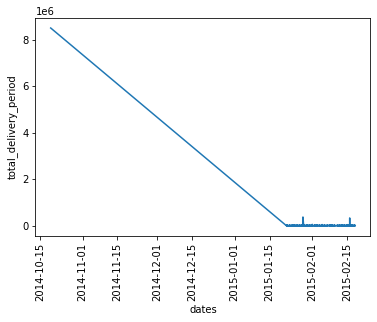

In [5]:
df = cleaned_historical_data.sort_values('created_at',ascending =True)
plt.plot(df['created_at'],df['total_delivery_period'])
plt.xticks(rotation ='vertical')
plt.xlabel('dates')
plt.ylabel('total_delivery_period')


### Outlier Detection

<AxesSubplot:xlabel='month', ylabel='total_delivery_period'>

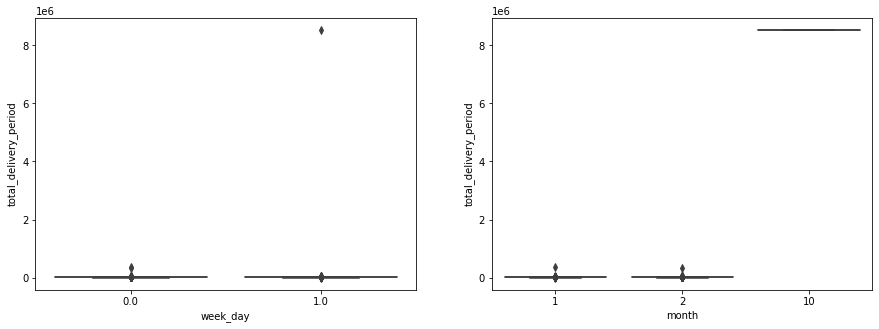

In [6]:
# Plotting weekend vs weekday for total delivery period
# Plotting by month for total delivery period

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (15,5))
sns.boxplot(x="week_day", y="total_delivery_period", data=cleaned_historical_data ,ax=ax1)
sns.boxplot(x="month", y="total_delivery_period", data=cleaned_historical_data ,ax=ax2)



<AxesSubplot:xlabel='day_of_week', ylabel='total_delivery_period'>

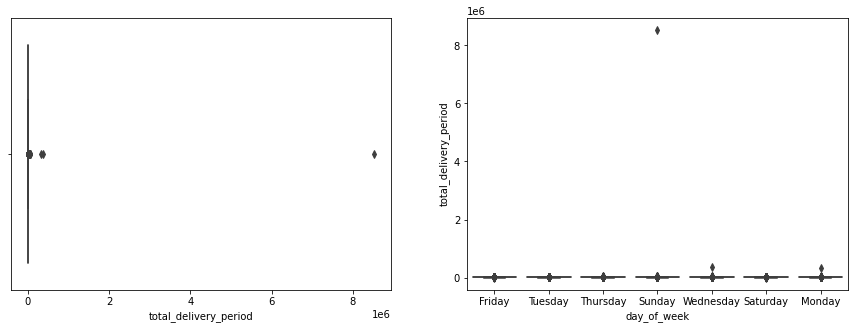

In [7]:
# Plotting total delivery period
# Plotting by day of the week for total delivery period
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (15,5))
sns.boxplot(x='total_delivery_period', data =cleaned_historical_data ,ax=ax1 )
sns.boxplot(x="day_of_week", y="total_delivery_period", data=cleaned_historical_data ,ax=ax2)



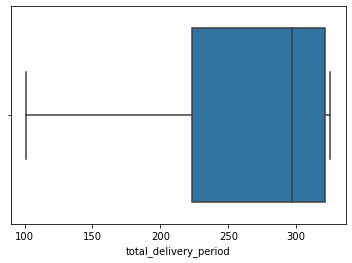

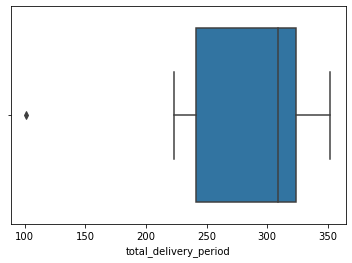

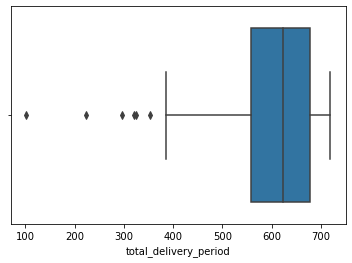

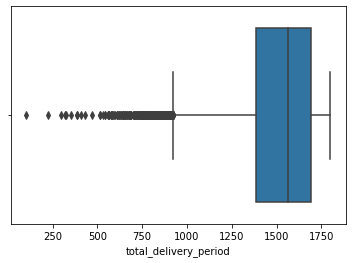

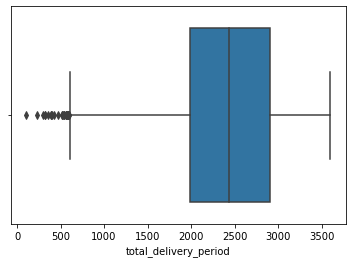

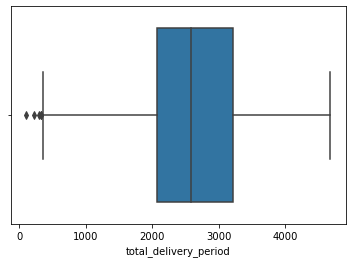

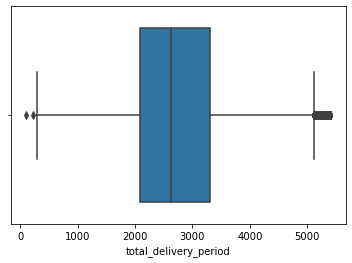

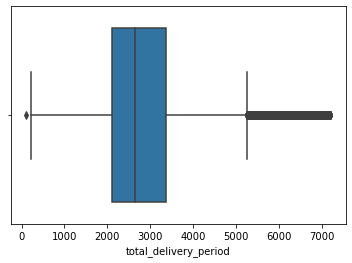

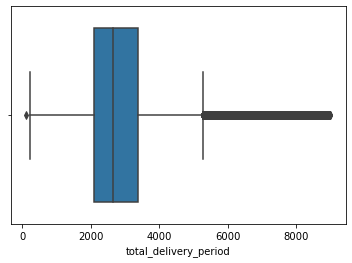

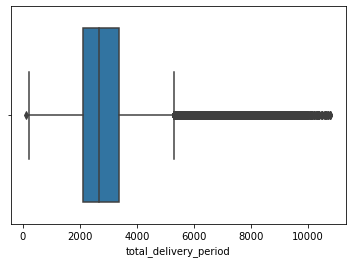

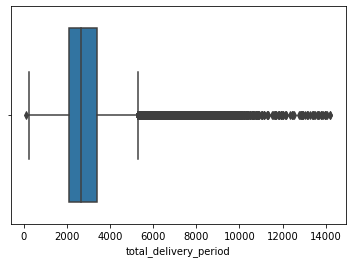

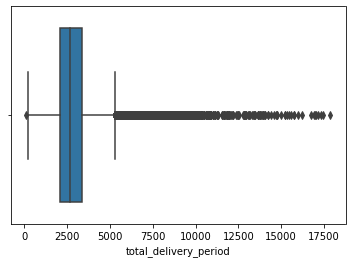

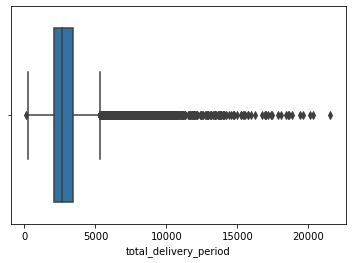

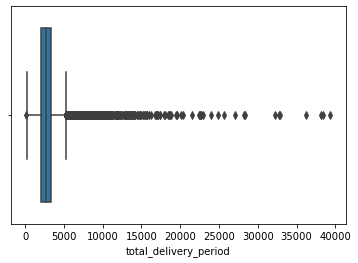

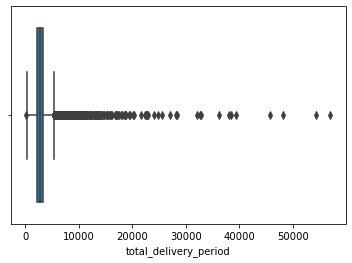

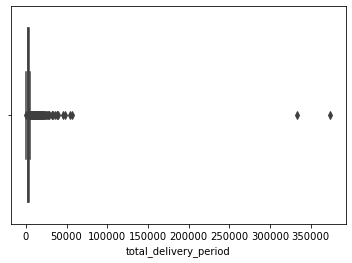

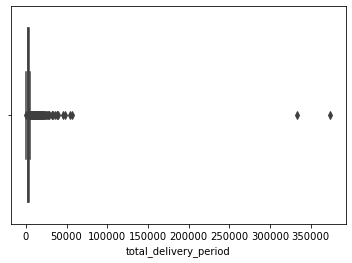

In [8]:
#Additional outlier checks
#checking with for outliers from values less than <0.1(6mins) hrs to <168 hrs(7days)

list_hr = [0.097,0.098,0.2,0.5,1,1.3,1.5,2,2.5,3,4,5,6,12,72,129,168]

for each_hr in list_hr:
    
    plt.figure()
    k = sns.boxplot(x= 'total_delivery_period', data =(cleaned_historical_data[cleaned_historical_data['total_delivery_period'] <= (each_hr * 3600)]))

    k

In [9]:
# Observing online information and the  exploring the DoorDash app 
# Orders can be scheduled within a week i.e 7 days, so it can be created a week in advance and
# these data points can be regarded as OK data points 
# orders greater than 7 days can be regarded as outliers, as orders can be placed at
# for example: 8am -  (3 hrs in advance to 7 days) in advance, while any order placed after 
# the 11:00am can be delivered between 30 mins in advance to 7 days in advance 

# it would be great to have datapoints showing the whether the order is scheduled or not 
# such as wait period after created_at to the point resturant starts on the order and any other time factor

#Given the variables and information available, assumptions as well exploration of the boxplots,
#outliers could be datapoints for total_delivery_period with values > 604,800 seconds and < 500 seconds
#additional information such as total processing time and wait time will required to make a best guess cut off for subsetting the data better

def outlier_detect(data):
    
    min_cut_off_min = 500
    
    max_cut_off_min = 3600 * 7 * 24
    
   # max_cut_off_min = 20000

    data.drop(data[data['total_delivery_period'] > (max_cut_off_min)].index, inplace = True)
    data.drop(data[data['total_delivery_period'] < (min_cut_off_min)].index, inplace = True)   
    return data.reset_index(drop = True)
   
        
outlier_removed_data = outlier_detect(data = cleaned_historical_data)  
outlier_removed_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196880 entries, 0 to 196879
Data columns (total 28 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196880 non-null  float64       
 1   created_at                                    196880 non-null  datetime64[ns]
 2   actual_delivery_time                          196880 non-null  datetime64[ns]
 3   store_id                                      196880 non-null  int64         
 4   store_primary_category                        196018 non-null  object        
 5   order_protocol                                196880 non-null  float64       
 6   total_items                                   196880 non-null  int64         
 7   subtotal                                      196880 non-null  int64         
 8   num_distinct_items                            196880 n

### Box plots with outlier threshold set 

<AxesSubplot:xlabel='day_of_week', ylabel='total_delivery_period'>

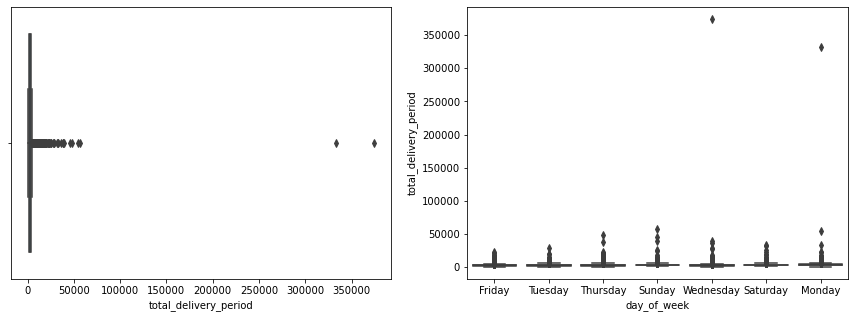

In [10]:
# Plotting total delivery period
# Plotting by day of the week for total delivery period
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (15,5))
sns.boxplot(x='total_delivery_period', data =outlier_removed_data ,ax=ax1 )
sns.boxplot(x="day_of_week", y="total_delivery_period", data=outlier_removed_data ,ax=ax2)


<AxesSubplot:xlabel='month', ylabel='total_delivery_period'>

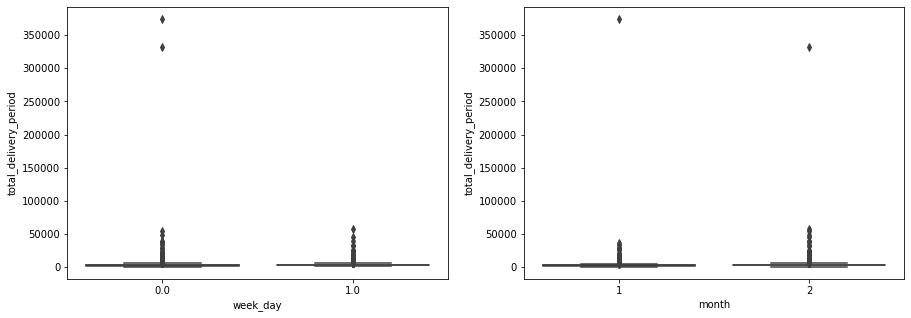

In [11]:
# Plotting weekend vs weekday for total delivery period
# Plotting by month for total delivery period
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (15,5))
sns.boxplot(x="week_day", y="total_delivery_period", data=outlier_removed_data ,ax=ax1)
sns.boxplot(x="month", y="total_delivery_period", data=outlier_removed_data,ax=ax2)


### Dealing with processing time variable (from order received time  to pick up time by dasher) or just any other time not accounted for 

In [13]:

mean_process_time = outlier_removed_data.groupby(['store_id'])['total_processing_time'].mean().to_dict()
median_process_time = outlier_removed_data.groupby(['store_id'])['total_processing_time'].median().to_dict()
min_process_time = outlier_removed_data.groupby(['store_id'])['total_processing_time'].min().to_dict()
max_process_time = outlier_removed_data.groupby(['store_id'])['total_processing_time'].max().to_dict()

cleaned_predict_data['mean_processing_time_per_category'] = cleaned_predict_data['store_id'].map(mean_process_time)
cleaned_predict_data['median_processing_time_per_category'] = cleaned_predict_data['store_id'].map(median_process_time)
cleaned_predict_data['min_processing_time_per_category'] = cleaned_predict_data['store_id'].map(min_process_time)
cleaned_predict_data['max_processing_time_per_category'] = cleaned_predict_data['store_id'].map(max_process_time)

def process_time_data(data,mean_time,median_time,min_time,max_time):
        
        if "actual_delivery_time" in data.columns:

            data['mean_processing_time_per_category'] = data.groupby(['store_id'])['total_processing_time'].transform('mean')
            data['median_processing_time_per_category'] = data.groupby(['store_id'])['total_processing_time'].transform('median')
            data['min_processing_time_per_category'] = data.groupby(['store_id'])['total_processing_time'].transform('min')
            data['max_processing_time_per_category'] = data.groupby(['store_id'])['total_processing_time'].transform('max') 

        else:
            data['mean_processing_time_per_category'] = data['store_id'].map(mean_process_time)
            data['median_processing_time_per_category'] = data['store_id'].map(median_process_time)
            data['min_processing_time_per_category'] = data['store_id'].map(min_process_time)
            data['max_processing_time_per_category'] = data['store_id'].map(max_process_time)

        return data 
        
processed_time_historical = process_time_data(outlier_removed_data,mean_process_time,median_process_time,min_process_time,max_process_time)
processed_time_predict= process_time_data(cleaned_predict_data,mean_process_time,median_process_time,min_process_time,max_process_time)


### Scheduled or Unscheduled orders

In [29]:
def hour_limit(x):
    
    #Assumption: Using 1hr as the maximum threshold for total processing time, the data set can be 
    #mapped to scheduled or scheduled
    
    #the tradeoff is orders scheduled between 30 mins to 1 hr ahead might be categirzed as unscheduled
    #it would be great to have actual data if the orders are scheduled or not
    
#   if the order is between 11-9 and processing time >1 - scheduled

        if 11 <= hour <= 21 and total_processing_time >3600:
            return 1
        else:
            return 0

return 1

            
    if x > 3600:
        #scheduled delivery
        return 1
    else:
        #not scheduled
        return 0

processed_time_historical['check_schedule'] = processed_time_historical['total_processing_time'].apply(hour_limit)
processed_time_predict['check_schedule']= processed_time_historical['mean_processing_time_per_category'].apply(hour_limit)

#checking count of scheduled vs not scheduled in train and test dat a


list_data = [processed_time_historical,processed_time_predict]
for i in list_data:
    plt.figure()
    ax = sns.countplot(x='check_schedule', data=i)
    ax.set_xticklabels(['not scheduled','scheduled'])
    
processed_time_historical['check_schedule'].value_counts()  
    
    
    

IndentationError: unexpected indent (<ipython-input-29-83b24ee17c7a>, line 19)

0    194439
1      2441
Name: check_schedule, dtype: int64

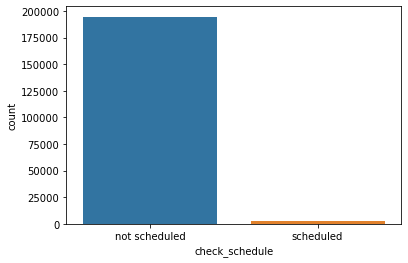

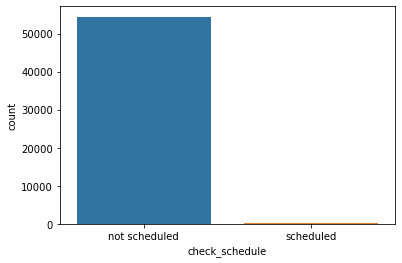

In [48]:
 #Assumption: Using 1hr as the maximum threshold for total processing time, the data set can be 
#mapped to scheduled or scheduled

#the tradeoff is orders scheduled between 30 mins to 1 hr ahead might be categirzed as unscheduled
#it would be great to have actual data if the orders are scheduled or not
    
#if the order is between 11-9 and processing time >1 - scheduled

def schedule(row):
    if 11 <= row['hour'] <= 21 and row['total_processing_time'] > 3600:
        val = 1
    else:
        val = 0
    return val

processed_time_historical['check_schedule'] = processed_time_historical.apply(schedule, axis=1) 
processed_time_predict['check_schedule']= processed_time_historical['mean_processing_time_per_category'].apply(hour_limit)
 
    
list_data = [processed_time_historical,processed_time_predict]
for i in list_data:
    plt.figure()
    ax = sns.countplot(x='check_schedule', data=i)
    ax.set_xticklabels(['not scheduled','scheduled'])
    
processed_time_historical['check_schedule'].value_counts()  

### Create Dummy variables(One hot encoding)

In [49]:
def get_enconder(cleansed_data):
    
    #generate binary values using get_dummies
    dum_df = pd.get_dummies(cleansed_data, columns=["time_of_day"], prefix=["time_of_day"])
    dum_df["time_of_day"] = cleansed_data["time_of_day"]

    dum_df_2 = pd.get_dummies(dum_df, columns=["day_of_week"], prefix=[""])
    dum_df_2["day_of_week"] =dum_df["day_of_week"]
    
    dum_df_3 = pd.get_dummies(dum_df_2, columns=["check_schedule"], prefix=["_schedule"])
    dum_df_3["check_schedule"] =dum_df_2["check_schedule"]

    final_df = pd.get_dummies(dum_df_3, columns=["week_day"], prefix=[""])
    final_df["week_day"] =dum_df_3["week_day"]

    
    return final_df
    
dummy_historical_data = get_enconder(processed_time_historical )
dummy_predict_data = get_enconder(processed_time_predict)
dummy_predict_data.head(10)






,market_id,created_at,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,_Thursday,_Tuesday,_Wednesday,day_of_week,_schedule_0,_schedule_1,check_schedule,_0.0,_1.0,week_day
0,3.0,2015-02-25 02:22:30,5477,thai,1.0,5,7500,4,800.0,1800,...,0,0,1,Wednesday,1,0,0,1,0,0.0
1,3.0,2015-02-25 01:14:19,5477,thai,1.0,5,7100,4,800.0,1500,...,0,0,1,Wednesday,1,0,0,1,0,0.0
2,4.0,2015-02-22 02:27:44,5477,thai,1.0,4,4500,2,750.0,1500,...,0,0,0,Sunday,1,0,0,0,1,1.0
3,3.0,2015-02-25 01:32:39,5477,thai,1.0,1,1700,1,1400.0,1400,...,0,0,1,Wednesday,1,0,0,1,0,0.0
4,1.0,2015-02-24 05:20:45,2841,italian,1.0,2,3150,2,1525.0,1625,...,0,1,0,Tuesday,1,0,0,1,0,0.0
5,1.0,2015-02-22 01:43:41,2841,italian,1.0,3,6815,3,1625.0,2995,...,0,0,0,Sunday,1,0,0,0,1,1.0
6,1.0,2015-02-23 20:09:23,4139,mexican,1.0,2,850,2,150.0,700,...,0,0,0,Monday,1,0,0,1,0,0.0
7,1.0,2015-02-22 05:57:23,5058,italian,1.0,1,1700,1,1700.0,1700,...,0,0,0,Sunday,1,0,0,0,1,1.0
8,1.0,2015-02-25 04:19:59,5058,italian,1.0,1,2179,1,1914.0,1832,...,0,0,1,Wednesday,1,0,0,1,0,0.0
9,1.0,2015-02-22 02:24:32,5058,italian,1.0,1,1800,1,1800.0,1800,...,0,0,0,Sunday,1,0,0,0,1,1.0


### Drop some categorical columns and datetime data types 

In [51]:
final_historical = dummy_historical_data.drop(columns = ["store_primary_category","time_of_day","minute","day_of_week","created_at","actual_delivery_time","created_at_time",'total_processing_time','Holiday','year'])
final_predict = dummy_predict_data.drop(columns = ["store_primary_category","time_of_day","minute","day_of_week","created_at",'created_at_time','Holiday','year'])
final_predict = dummy_predict_data.dropna(subset=['estimated_store_to_consumer_driving_duration']).reset_index(drop =True)

final_predict.isna().sum()
final_historical.isna().sum()

market_id                                       0
store_id                                        0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  5
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_period                           0
month                                           0
day                                             0
hour                                            0
mean_processing_time_per_category               0
median_processing_time_per_category             0
min_processing_time_per_category                0


In [52]:
#drop 5 columns of min item price that couldnt be filled with group by store_id

final_predict = final_predict.dropna()
final_predict = final_predict.reset_index(drop =True)


final_historical = final_historical.dropna()
final_historical = final_historical.reset_index(drop =True)

final_predict.isna().sum()
final_historical.isna().sum()



market_id                                       0
store_id                                        0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_period                           0
month                                           0
day                                             0
hour                                            0
mean_processing_time_per_category               0
median_processing_time_per_category             0
min_processing_time_per_category                0


## Feature Selection

### SelectK

['mean_processing_time_per_category',
 'median_processing_time_per_category',
 '_schedule_0',
 '_schedule_1',
 'check_schedule',
 'estimated_store_to_consumer_driving_duration',
 'min_processing_time_per_category',
 'subtotal',
 'total_outstanding_orders',
 'hour']

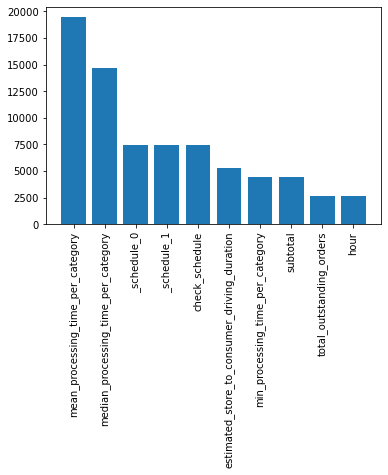

In [53]:
def get_model_features(data):
    
    
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    
    X = data.drop("total_delivery_period", axis = 1)  #independent columns
    y = data['total_delivery_period']   #target column
    
    #apply SelectKBest class to select top 10 best features
    bestfeatures = SelectKBest(score_func=f_regression,k=10)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    #join two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Score']  #naming the dataframe columns
    sorted_features = featureScores.sort_values(by ="Score", ascending = False)
    top_ten = sorted_features.head(10)
    f, ax = plt.subplots()

    x = top_ten['Features'].to_list()
    l = [range(0,len(x))]

    ax.bar(top_ten['Features'], top_ten['Score'])
    ax.set_xticklabels(x,rotation = 'vertical')

    return top_ten['Features'].to_list()

get_model_features(final_historical)


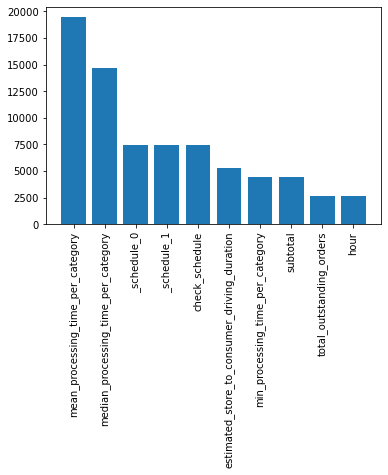

In [54]:
hist_model_data = get_model_features(final_historical)



In [55]:
hist_model_data.append('total_delivery_period')
hist_model_data

['mean_processing_time_per_category',
 'median_processing_time_per_category',
 '_schedule_0',
 '_schedule_1',
 'check_schedule',
 'estimated_store_to_consumer_driving_duration',
 'min_processing_time_per_category',
 'subtotal',
 'total_outstanding_orders',
 'hour',
 'total_delivery_period']

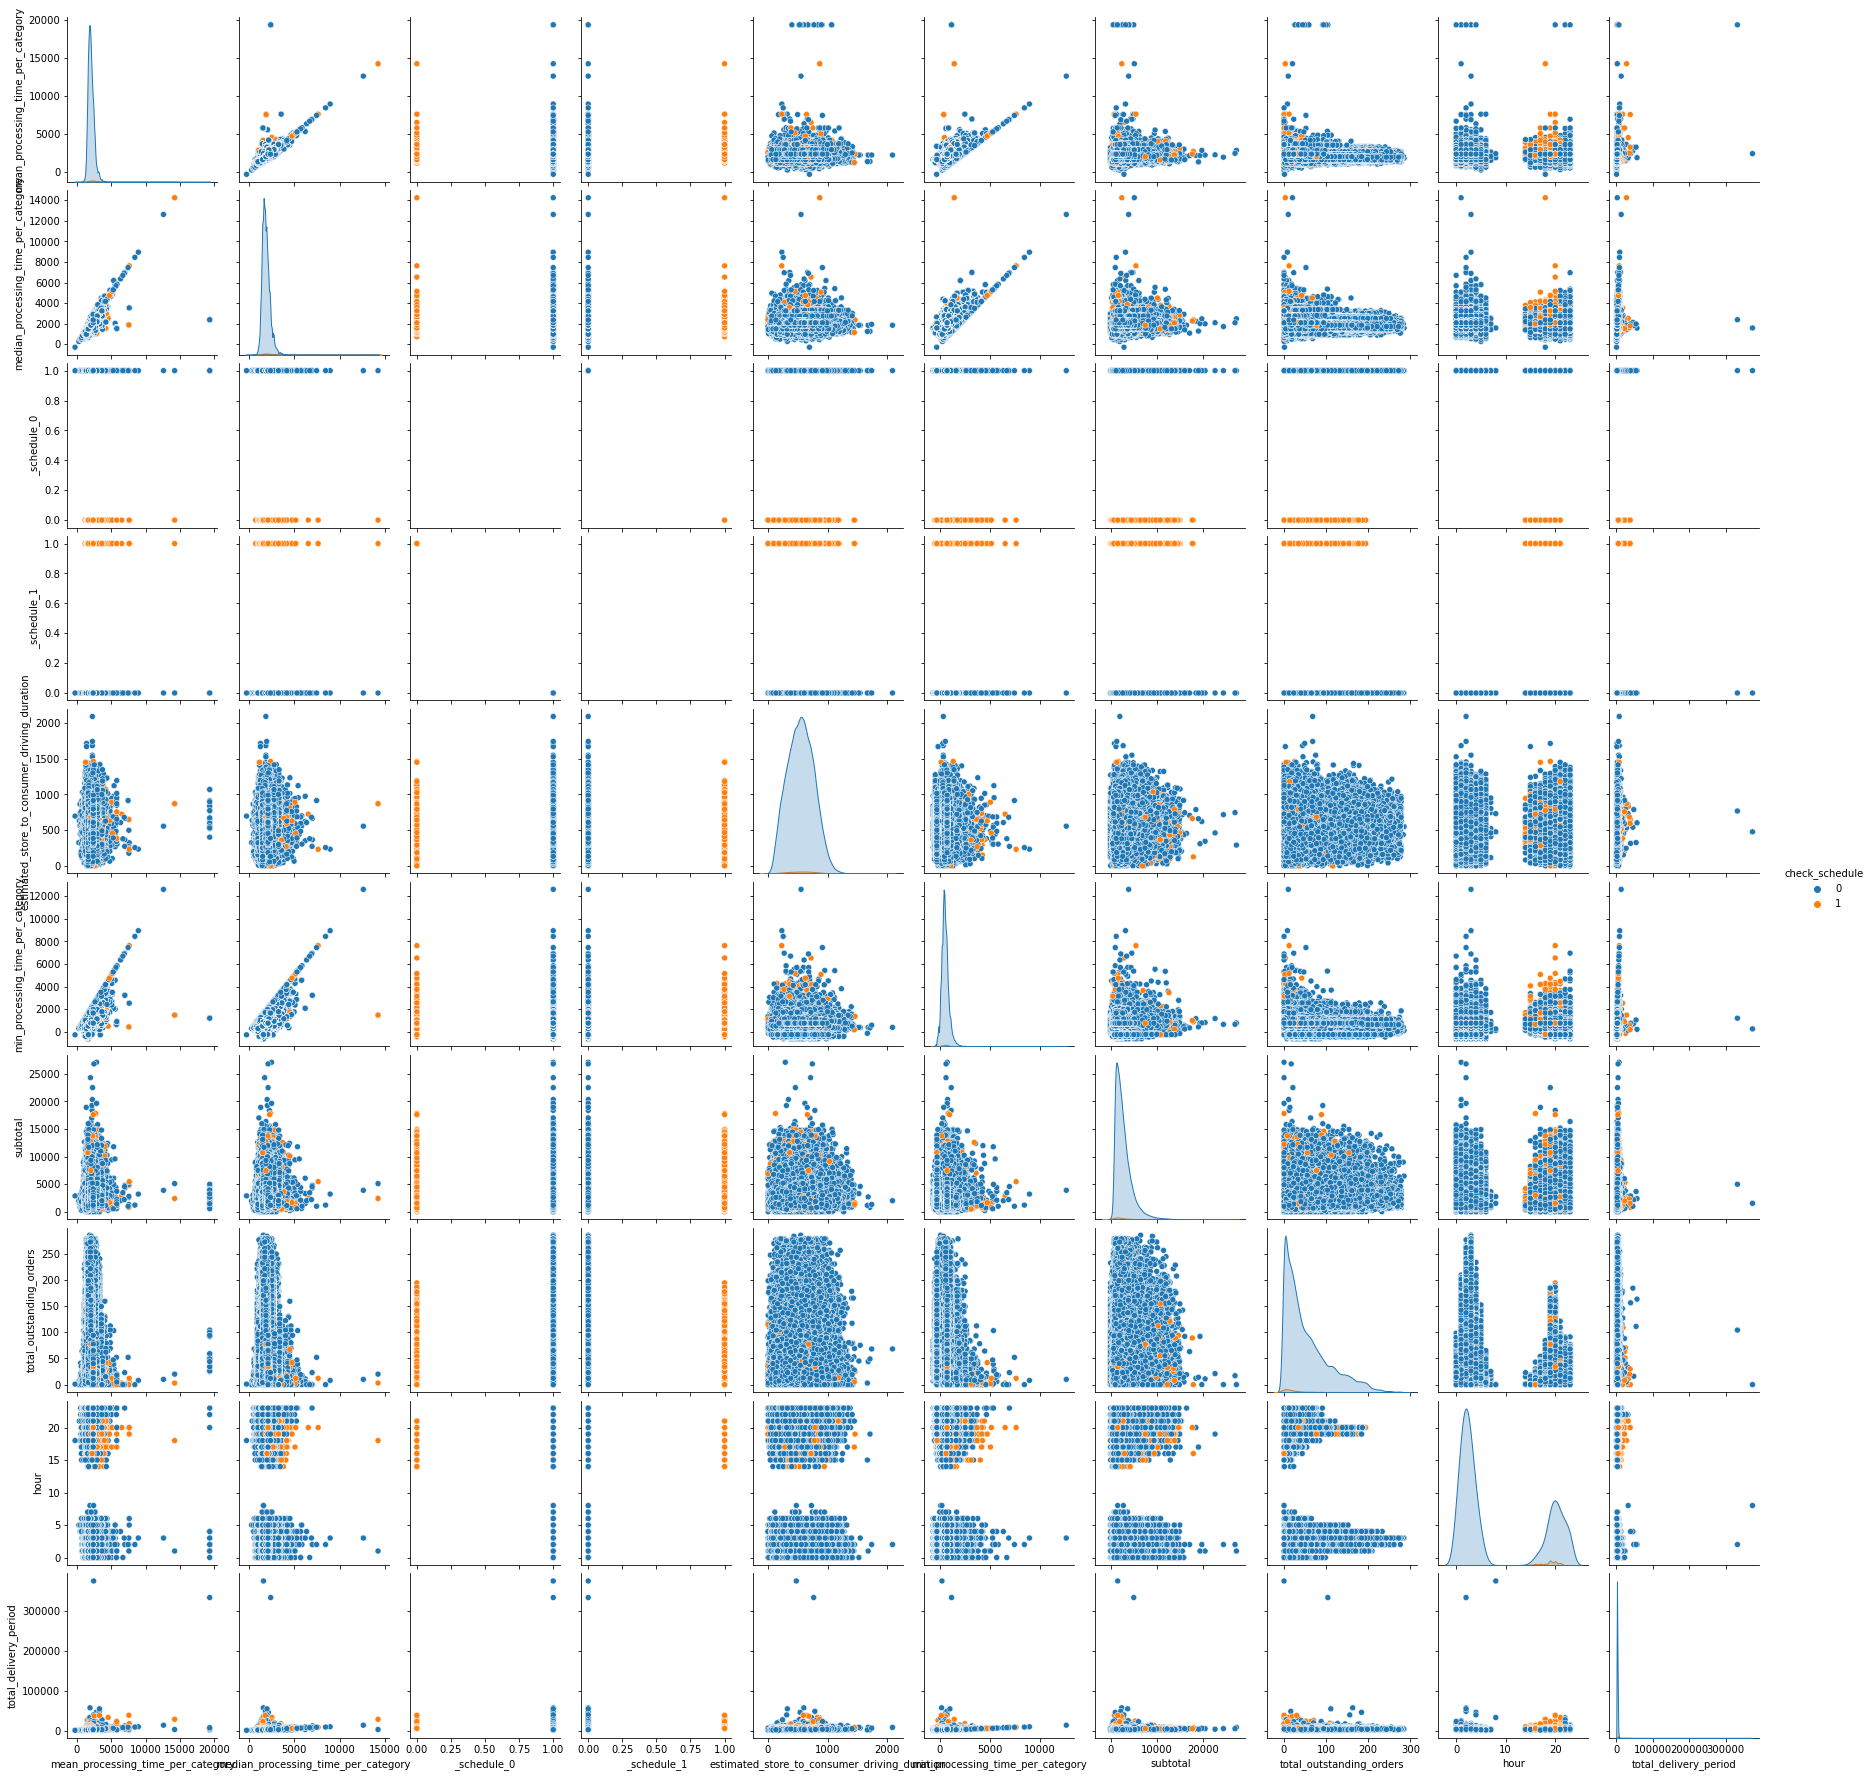

In [40]:
sns.pairplot(final_historical[hist_model_data], hue ='check_schedule')

['mean_processing_time_per_category',
 'median_processing_time_per_category',
 '_schedule_0',
 '_schedule_1',
 'check_schedule',
 'estimated_store_to_consumer_driving_duration',
 'min_processing_time_per_category',
 'subtotal',
 'total_outstanding_orders',
 'hour']

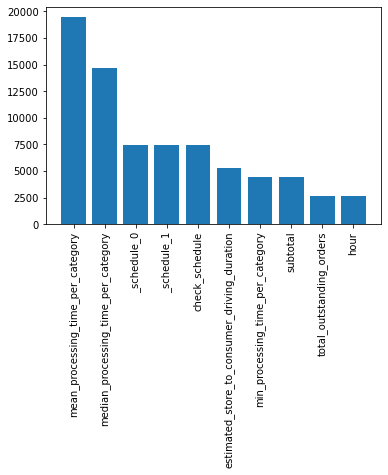

In [57]:
predict_data_features = (get_model_features(data = final_historical))
predict_data_features


### Principal Component Analysis 

In [58]:
from sklearn.decomposition import PCA

X_train = final_historical[hist_model_data].drop("total_delivery_period", axis = 1) 
X_test = final_predict[predict_data_features]

pca = PCA(n_components= 5)
pca_table = pca.fit_transform(X_train)

explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
cum_explained_variance = pd.DataFrame(np.cumsum((pca.explained_variance_ratio_)))

explained_variance.columns = ['explained_variance']
cum_explained_variance.columns = ['cum_explained_variance']


variance_table = pd.concat([explained_variance,cum_explained_variance],axis = 1).T
variance_table.columns = ['pc_1','pc_2','pc_3','pc_4','pc_5']
variance_table

,pc_1,pc_2,pc_3,pc_4,pc_5
explained_variance,0.84785,0.109131,0.023813,0.012144,0.006393
cum_explained_variance,0.84785,0.956981,0.980794,0.992939,0.999332


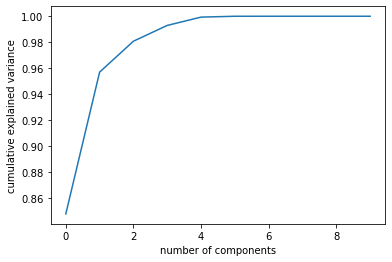

In [44]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


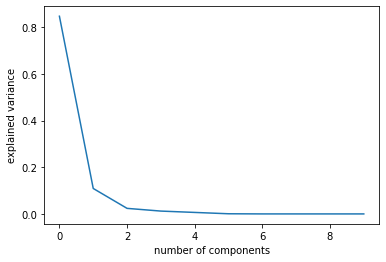

In [59]:
#Train data 
pca_plot = PCA().fit(X_train)
plt.plot((pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance');


In [60]:
#Choose 1st 2 principal components as they account for over 95% of the variance 
pca_data = PCA(n_components=10)
pca_train_data = pd.DataFrame(pca_data.fit_transform(X_train))
print(pca_train_data)
pca_test_data = pd.DataFrame(pca_data.fit_transform(X_test))
print(pca_test_data)

                  0            1            2           3           4  \
0        852.609382  1409.525218 -1462.541843  429.101943  -61.306508   
1       -805.004902  -292.399874   -81.927956  152.854068  231.284495   
2       -805.011356  -292.386143   -82.010464  152.849924  231.346232   
3       4181.861628  -627.823783  -127.531109 -267.649086  246.978828   
4       1190.291454  -426.795440   -90.558765  104.714977  237.961025   
...             ...          ...          ...         ...         ...   
196870 -1259.375619   574.654653   -36.938708 -206.242482   50.897519   
196871   360.341809   464.770751     3.024534  369.254181   60.096136   
196872  -811.384899   543.718182    -1.718445  254.539791   54.448636   
196873 -1439.659030  1099.120007  -799.023932  -91.468426 -108.954478   
196874   -13.945850  1003.344766  -822.054234 -346.611939 -105.536728   

                5          6         7             8             9  
0       30.969381  16.126087 -0.106199  1.305214e-13  

### Distribution of Categorical Values 

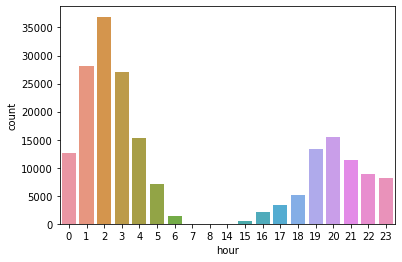

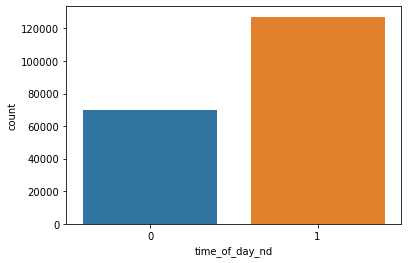

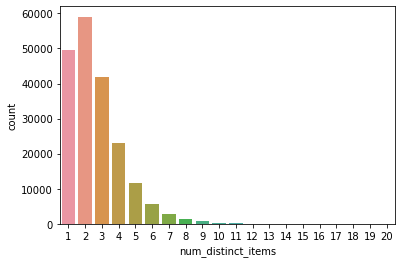

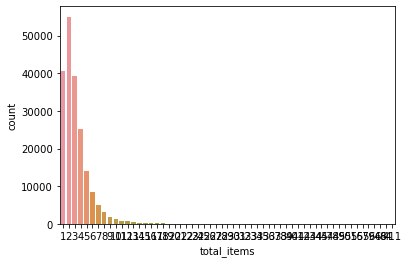

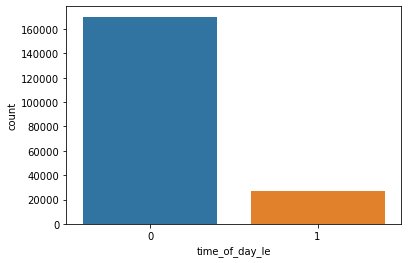

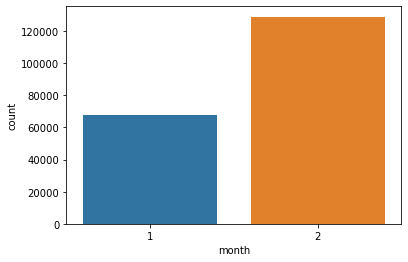

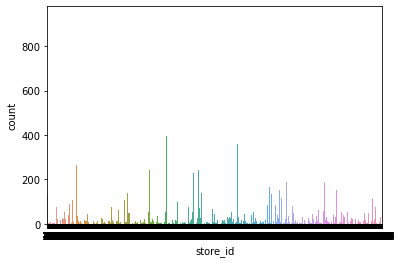

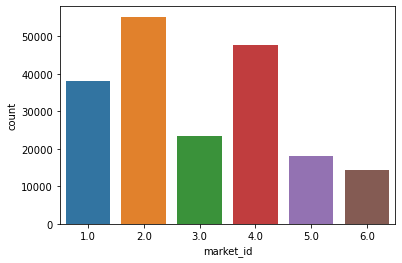

In [27]:
l = ["hour" ,"time_of_day_nd" ,"num_distinct_items", "total_items" ,"time_of_day_le",'month','store_id','market_id']
for i in l:
    plt.figure()
    sns.countplot(x=i, data=final_historical)

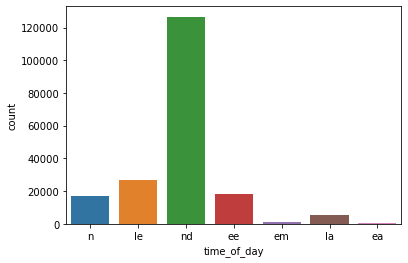

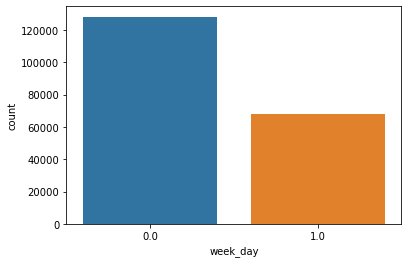

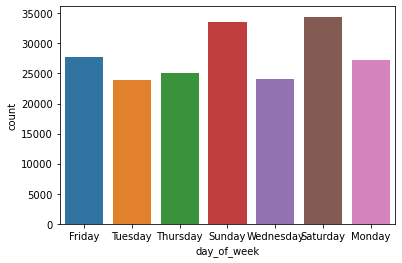

In [27]:
l=['time_of_day',"week_day","day_of_week"]

for i in l:
    plt.figure()
    sns.countplot(x=i, data=dummy_historical_data.dropna())
    
    

### Distribution of Continous Variables 

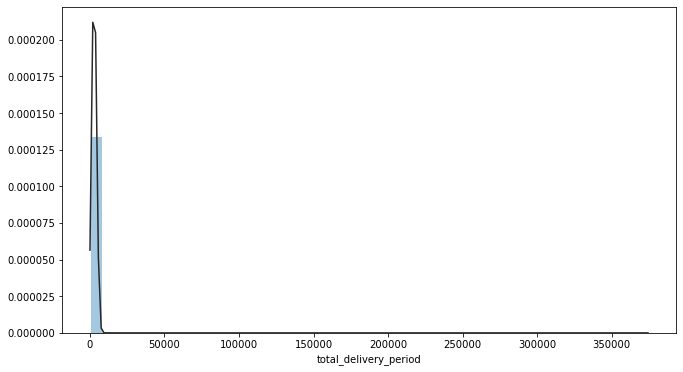

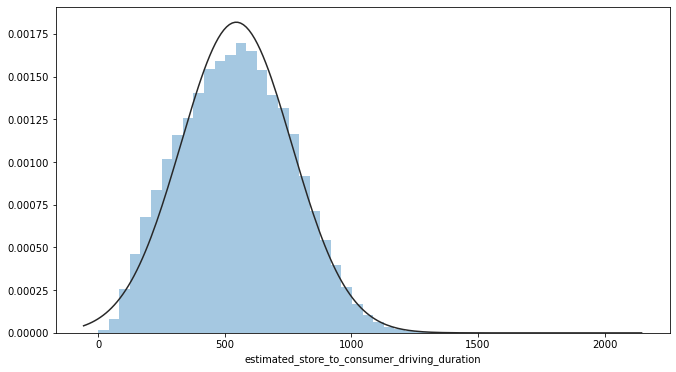

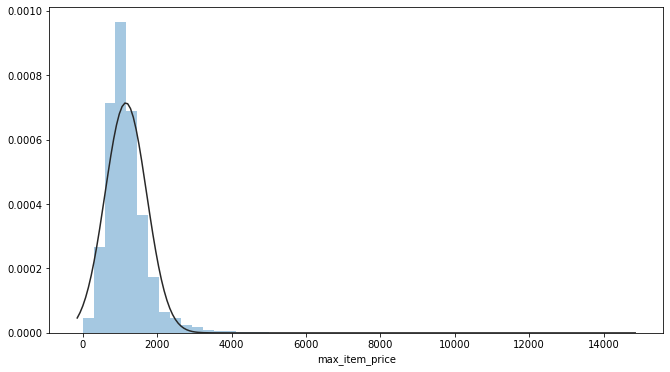

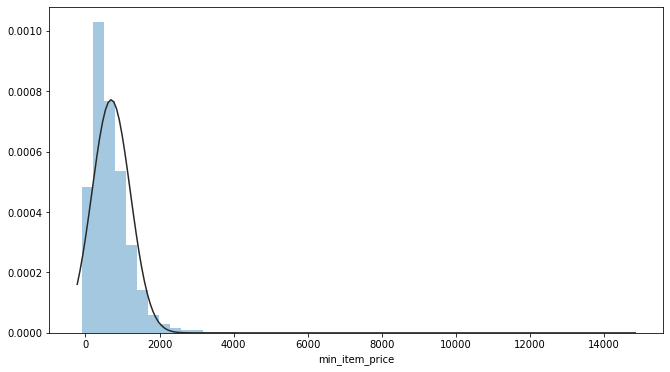

In [28]:
from scipy.stats import norm
l= [final_historical['total_delivery_period'],final_historical['estimated_store_to_consumer_driving_duration'],final_historical['max_item_price'],final_historical['min_item_price']]
for i in l:
    plt.figure(figsize=(11,6))
    sns.distplot(i,fit=norm, kde=False)

## Model Selection

### Multicollinaerity checks 

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x= final_historical[hist_model_data].drop("total_delivery_period", axis = 1) 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif.round(1))


   VIF Factor                                      features
0         4.3             mean_processing_time_per_category
1         4.6           median_processing_time_per_category
2        31.8                                   _schedule_0
3         inf                                   _schedule_1
4         inf                                check_schedule
5         1.0  estimated_store_to_consumer_driving_duration
6         1.5              min_processing_time_per_category
7         1.1                                      subtotal
8         1.2                      total_outstanding_orders
9         1.2                                          hour


### Run Model and Save predicted duration to csv file 

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

delivery_id_test = final_predict['delivery_id']
y_train = final_historical[hist_model_data]['total_delivery_period']

#Select k best features 
x_train = final_historical[hist_model_data].drop("total_delivery_period", axis = 1) 
x_test = final_predict[predict_data_features]


def model_test(X_train,Y_train,X_test,delivery_id):

    dict_classifiers = {
        
    "lr":LinearRegression(),
    "lasso_r":Lasso(),
    "rf": RandomForestRegressor(),
    'DTR_r': DecisionTreeRegressor(),
}
    
    for each_model, model_instantiation in dict_classifiers.items():          
            model_instantiation.fit(X_train,Y_train)
            model_results = pd.DataFrame()
            model_results['delivery_id']= delivery_id
            model_results['predicted duration']= round(pd.DataFrame(model_instantiation.predict(X_test)),3)
            file = model_results.to_csv(f'{each_model}_submission.csv', index = False)
            
    return file
   
               
model_test(x_train,y_train,x_test,delivery_id_test)


### Check Model feasibility using train data 

                Model Used         RMSE         MAE
0       LinearRegression()   960.049924  672.428961
1                  Lasso()   960.392174  672.389443
2  RandomForestRegressor()  1016.244439  668.606591
3  DecisionTreeRegressor()  1374.226112  926.852571
                Model Used  R2-Score
0       LinearRegression()  0.298733
1                  Lasso()  0.298233
2  RandomForestRegressor()  0.214236
3  DecisionTreeRegressor() -0.436852
90.65 sec


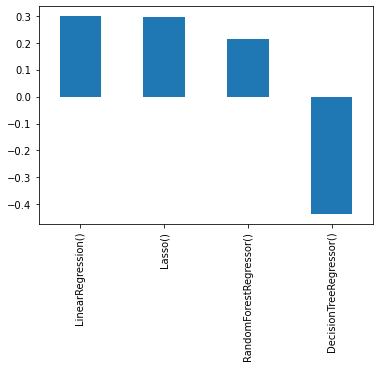

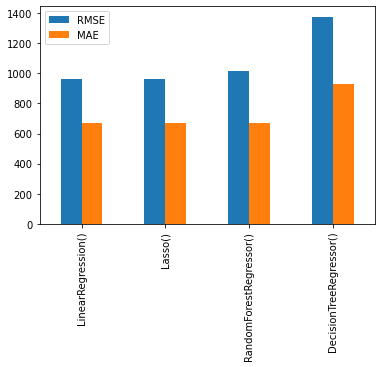

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


delivery_id_test = final_predict['delivery_id']
y = final_historical[hist_model_data]['total_delivery_period']
x = final_historical[hist_model_data].drop('total_delivery_period',axis =1)


lr_pca=LinearRegression()
lasso_r_pca =Lasso()
rf_pca = RandomForestRegressor()
DTR_r_pca = DecisionTreeRegressor()

model_list=[lr_pca,lasso_r_pca,rf_pca,DTR_r_pca]

def model_test(delivery_id):
    
    start_time=time()
    R2_Score=[]
    RMSE_list = []
    MSE_list = []
    MAE_list = []
 
    dict_classifiers = {
        
    "lr_pca":LinearRegression(),
    "lasso_r_pca":Lasso(),
    'rf_pca': RandomForestRegressor(),
    'DTR_r_pca': DecisionTreeRegressor(),
}
    
    for each_model, model_instantiation in dict_classifiers.items():
        
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.2,random_state=50)
        
        model_instantiation.fit(x_train,y_train)
        model_results = pd.DataFrame()
        model_results['delivery_id']= delivery_id
        model_results['total_delivery_period']= round(pd.DataFrame(model_instantiation.predict(x_test)),3)

        y_pred=model_instantiation.predict(x_test)
        score=r2_score(y_test,y_pred)
        R2_Score.append(score)
        
        MSE = mean_squared_error(y_test, y_pred)
        MSE_list.append(MSE)
        RMSE = np.sqrt(MSE)
        RMSE_list.append(RMSE)
        MAE = mean_absolute_error(y_test, y_pred)
        MAE_list.append(MAE)
        
        
        msg = "%s = %.2f" % (each_model,round(RMSE, 2))
        msg = "%s = %.2f" % (each_model,round(MSE, 2))
        msg = "%s = %.2f" % (each_model,round(MAE, 2))
 
        R2_data = (pd.DataFrame(zip(model_list,R2_Score),columns=['Model Used','R2-Score']))
        metrics_data = (pd.DataFrame(zip(model_list,RMSE_list,MAE_list),columns=['Model Used','RMSE','MAE']))
    

    print(metrics_data)
    print(R2_data)
    
    ax = R2_data['R2-Score'].plot(kind = 'bar')
    ax.set_xticks(R2_data.index)
    ax.set_xticklabels(R2_data['Model Used'], rotation=90)

    
    ax = metrics_data[['RMSE','MAE']].plot(kind = 'bar')
    ax.set_xticks(metrics_data.index)
    ax.set_xticklabels(metrics_data['Model Used'], rotation=90)
   
    
    end_time=time()
    print(round(end_time-start_time,2),'sec')
    
model_test(delivery_id_test)
